# Elaine Zhang Sleep Inference

## Importing Data and Data Cleaning

In [46]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt

In [47]:
file_path = "EZ_data/history_chrome.json"

with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)  # Load JSON data

history_list = data["Browser History"]  # Extract history data
elaine_chrome_history = pd.DataFrame(history_list)
elaine_chrome_history.head(1)


,favicon_url,page_transition_qualifier,title,url,time_usec,client_id
0,https://www.google.com/favicon.ico,CLIENT_REDIRECT,Google Takeout,https://takeout.google.com/,1740333261934643,GDY74/DpgCDxMCldA15OWg==


In [48]:
elaine_chrome_history["datetime"] = pd.to_datetime(elaine_chrome_history["time_usec"], unit="us")
elaine_chrome_history["date"] = elaine_chrome_history["datetime"].dt.date  # Extract date (YYYY-MM-DD)
elaine_chrome_history["time"] = elaine_chrome_history["datetime"].dt.time

elaine_chrome_history.head(3)

,favicon_url,page_transition_qualifier,title,url,time_usec,client_id,datetime,date,time
0,https://www.google.com/favicon.ico,CLIENT_REDIRECT,Google Takeout,https://takeout.google.com/,1740333261934643,GDY74/DpgCDxMCldA15OWg==,2025-02-23 17:54:21.934643,2025-02-23,17:54:21.934643
1,https://www.google.com/favicon.ico,CLIENT_REDIRECT,Google Takeout,https://takeout.google.com/,1740333259460484,GDY74/DpgCDxMCldA15OWg==,2025-02-23 17:54:19.460484,2025-02-23,17:54:19.460484
2,,CLIENT_REDIRECT,cs6501-4501-analyzing-online-behavior,https://henrykautz.com/Teaching/cs6501-4501-an...,1740333252069420,GDY74/DpgCDxMCldA15OWg==,2025-02-23 17:54:12.069420,2025-02-23,17:54:12.069420


In [66]:
# tally up keywords
keywords = ["uva", "canvas", "zzb2rf", "drive"]

tally_data = []
last_time_per_date = {}

for _, row in elaine_chrome_history.iterrows():
    row_tally = {"date": row["date"], "total_count": 0}
    
    # Count occurrences of each keyword
    for keyword in keywords:
        count = sum(row.astype(str).str.contains(keyword, case=False, na=False))
        row_tally[keyword] = count
        row_tally["total_count"] += count

    if row["date"] not in last_time_per_date:
        last_time_per_date[row["date"]] = row["time"]
    else:
        if row["time"] > last_time_per_date[row["date"]]:
            last_time_per_date[row["date"]] = row["time"]
    
    tally_data.append(row_tally)

tally_df = pd.DataFrame(tally_data)
summary_df = tally_df.groupby("date", as_index=False).sum()
summary_df["last_time"] = summary_df["date"].map(last_time_per_date)

In [67]:
# double check to see if any dates are missing, if so, add them to my df
summary_df["date"] = pd.to_datetime(summary_df["date"])

full_date_range = pd.date_range(start=summary_df["date"].min(), end=summary_df["date"].max(), freq="D")
missing_dates = full_date_range[~full_date_range.isin(summary_df["date"])]

missing_rows = []
for missing_date in missing_dates:
    missing_row = {"date": missing_date, "total_count": 0, "uva": 0, "canvas": 0, "zzb2rf": 0, "drive": 0}
    missing_rows.append(missing_row)
missing_df = pd.DataFrame(missing_rows)

summary_df = pd.concat([summary_df, missing_df], ignore_index=True)
summary_df = summary_df.sort_values("date").reset_index(drop=True)

summary_df.head()

,date,total_count,uva,canvas,zzb2rf,drive,last_time
0,2024-02-24,249,240,9,0,0,23:59:19.643779
1,2024-02-25,81,73,8,0,0,21:35:06.019102
2,2024-02-26,99,66,8,14,11,23:58:31.877866
3,2024-02-27,57,22,21,6,8,23:56:58.414184
4,2024-02-28,126,62,34,15,15,23:59:05.722954


In [68]:
summary_df.to_csv('elaine_uva_keywords_chrome.csv')

## Sleep Inference

In [60]:
# get the first and last visited websites per date

def get_first_and_last_visits(df):
    # find first and last visited websites per date
    first_visits = df.loc[df.groupby("date")["time"].idxmin()]
    last_visits = df.loc[df.groupby("date")["time"].idxmax()]

    # select relevant columns
    first_visits = first_visits[["date", "time", "url", "title"]].rename(columns={
        "time": "visit_time_first",
        "url": "url_first",
        "title": "title_first"
    })
    
    last_visits = last_visits[["date", "time", "url", "title"]].rename(columns={
        "time": "visit_time_last",
        "url": "url_last",
        "title": "title_last"
    })

    # merge both DataFrames on visit_date to get one row per date
    visit_summary = pd.merge(first_visits, last_visits, on="date")
    visit_summary["visit_time_first"] = pd.to_datetime(visit_summary["visit_time_first"].astype(str), format='%H:%M:%S.%f')
    visit_summary["visit_time_last"] = pd.to_datetime(visit_summary["visit_time_last"].astype(str), format='%H:%M:%S.%f')
    return visit_summary

visit_summary_df = get_first_and_last_visits(elaine_chrome_history)
visit_summary_df.tail(2)

,date,visit_time_first,url_first,title_first,visit_time_last,url_last,title_last
292,2025-02-22,1900-01-01 00:32:49.837174,https://docs.google.com/presentation/u/3/d/1le...,Long Context Language Models - Google Slides,1900-01-01 16:49:37.349652,https://henrykautz.com/Teaching/odgers.pdf,Annual Research Review: Adolescent mental heal...
293,2025-02-23,1900-01-01 03:32:30.047999,https://chatgpt.com/c/67b9ecae-c550-8001-b028-...,Sleep Data Extraction,1900-01-01 17:54:21.934643,https://takeout.google.com/,Google Takeout


In [52]:
sleep_df = pd.read_csv('elaine_sleep_data.csv')
print(visit_summary_df["visit_time_first"].dtype)
visit_summary_df["visit_time_last"] = pd.to_datetime(visit_summary_df["visit_time_last"])

datetime64[ns]


In [ ]:

sns.set_theme(style="whitegrid")

# Convert datetime columns
sleep_df["Date"] = pd.to_datetime(sleep_df["Date"])  # Sleep recorded by morning of the date

print(visit_summary_df["visit_time_first"].dtype)

visit_summary_df["Sleep Date"] = visit_summary_df["date"].where(
    visit_summary_df["visit_time_last"].dt.hour < 4,  # Check if search time is before 4 AM
    visit_summary_df["date"] - pd.Timedelta(days=1)  # Subtract one day if it's after 4 AM
)

visit_summary_df["Sleep Date"] = pd.to_datetime(visit_summary_df["Sleep Date"])

# print(visit_summary_df["Sleep Date"].dtype)
# print(sleep_df["Date"][1])

# Merge sleep and search data
merged_df = sleep_df.merge(visit_summary_df, left_on="Date", right_on="Sleep Date", how="left")

# Convert last search time into a numeric hour for plotting
merged_df["search_hour"] = pd.to_datetime(merged_df["visit_time_last"], format="%H:%M:%S").dt.hour + \
                            pd.to_datetime(merged_df["visit_time_last"], format="%H:%M:%S").dt.minute / 60

merged_df["Date"] = pd.to_datetime(merged_df["Date"])

start_date = "2025-01-01"
end_date = "2025-02-17"

merged_df = merged_df[(merged_df["Date"] >= start_date) & (merged_df["Date"] <= end_date)]


datetime64[ns]
47


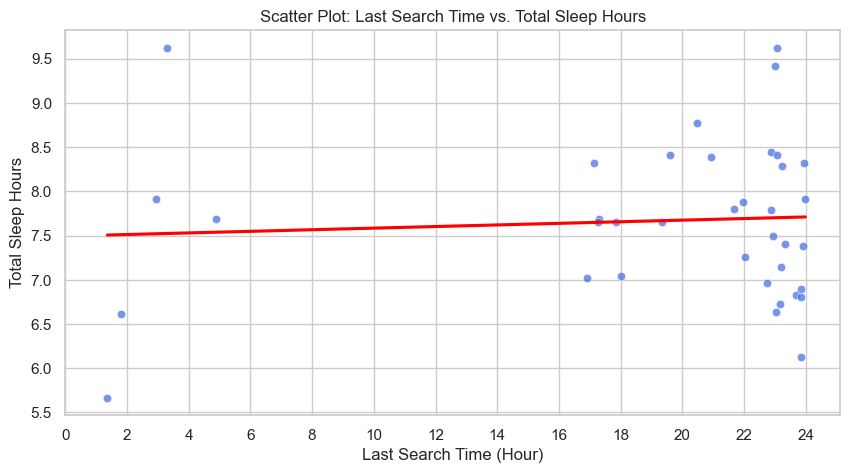

C:\Users\elzha\AppData\Local\Temp\ipykernel_16188\772647434.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="search_range", y="total_sleep_hours", palette="coolwarm")


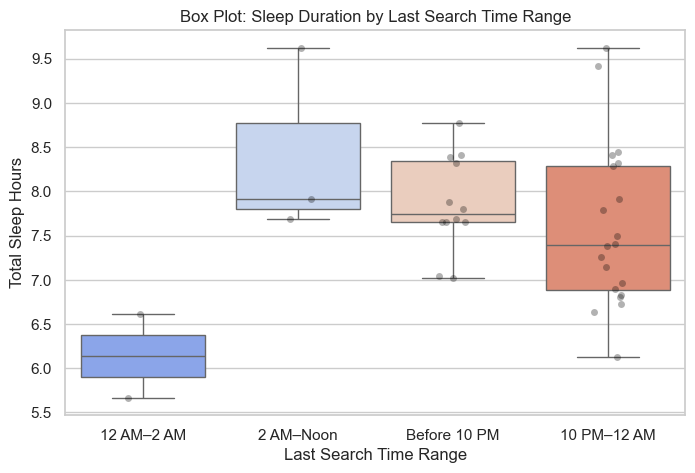

C:\Users\elzha\AppData\Local\Temp\ipykernel_16188\772647434.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged_df, x="search_range", y="total_sleep_hours", palette="coolwarm", inner="quartile")


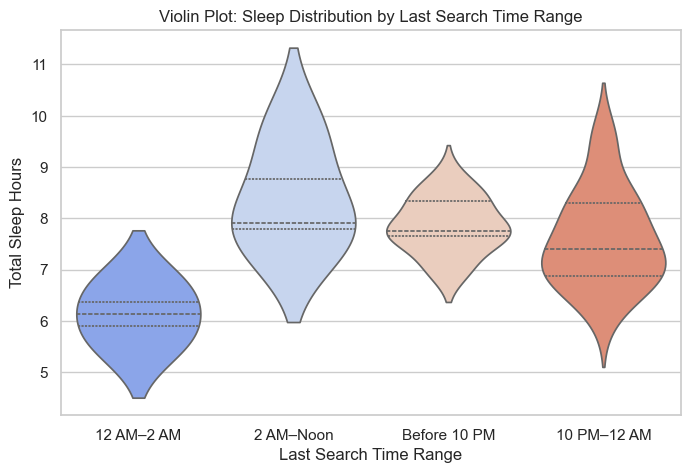

In [57]:
# Last search hour vs actual sleep time
plt.figure(figsize=(10, 5))
sns.scatterplot(data=merged_df, x="search_hour", y="total_sleep_hours", alpha=0.7, color="royalblue")
sns.regplot(data=merged_df, x="search_hour", y="total_sleep_hours", scatter=False, color="red", ci=None)  # Trendline
plt.xlabel("Last Search Time (Hour)")
plt.ylabel("Total Sleep Hours")
plt.title("Scatter Plot: Last Search Time vs. Total Sleep Hours")
plt.xticks(range(0, 25, 2))  # Show time as hours
plt.show()

merged_df["search_range"] = pd.cut(
    merged_df["search_hour"],
    bins=[0, 2, 12, 22, 24],  # Before 10 PM, 10 PM–12 AM, 12 AM–2 AM, 2 AM–Noon
    labels=["12 AM–2 AM", "2 AM–Noon", "Before 10 PM", "10 PM–12 AM"],
    ordered=True
)

plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df, x="search_range", y="total_sleep_hours", palette="coolwarm")
sns.stripplot(data=merged_df, x="search_range", y="total_sleep_hours", color="black", alpha=0.3, jitter=True)  # Add individual points
plt.xlabel("Last Search Time Range")
plt.ylabel("Total Sleep Hours")
plt.title("Box Plot: Sleep Duration by Last Search Time Range")
plt.show()

plt.figure(figsize=(8, 5))
sns.violinplot(data=merged_df, x="search_range", y="total_sleep_hours", palette="coolwarm", inner="quartile")
plt.xlabel("Last Search Time Range")
plt.ylabel("Total Sleep Hours")
plt.title("Violin Plot: Sleep Distribution by Last Search Time Range")
plt.show()


In [70]:
# Analyzing UVA related searches and sleep times
keywords_df = pd.read_csv('EZ_data/elaine_uva_keywords_chrome.csv')
keywords_df["last_time"] = pd.to_datetime(keywords_df["last_time"], format="%H:%M:%S.%f").dt.hour + \
                  pd.to_datetime(keywords_df["last_time"], format="%H:%M:%S.%f").dt.minute / 60  # Convert to float hours

keywords_df["date"] = pd.to_datetime(keywords_df["date"])

start_date = "2025-01-01"
end_date = "2025-02-17"

keywords_df = keywords_df[(keywords_df["date"] >= start_date) & (keywords_df["date"] <= end_date)]

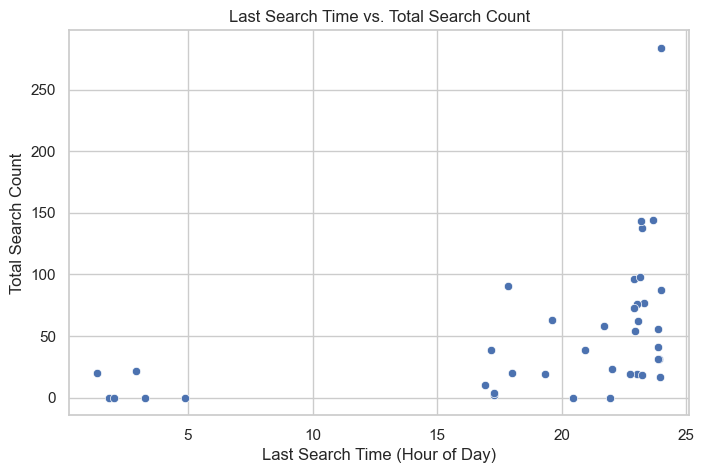

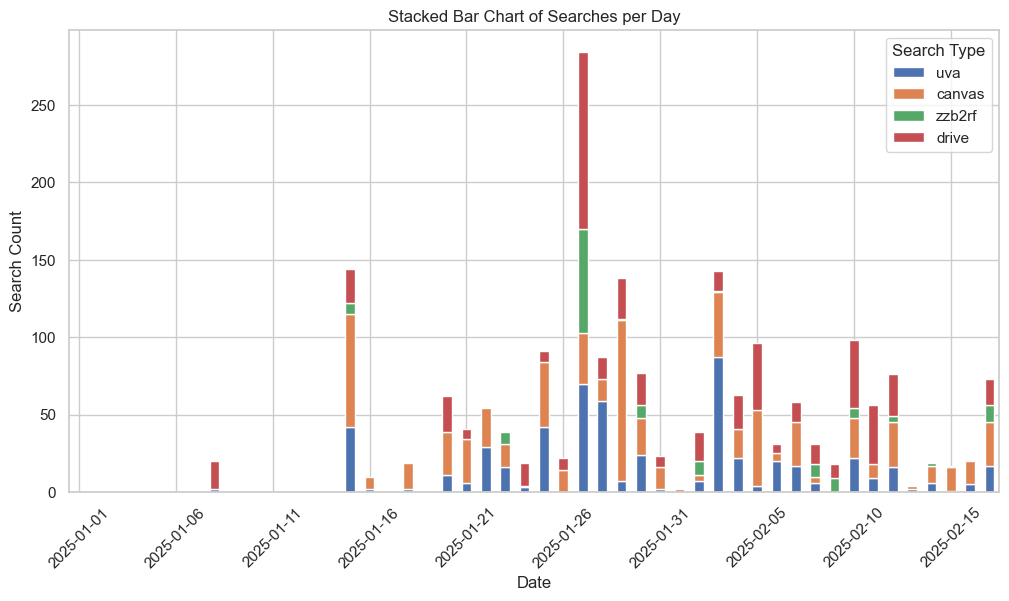

In [75]:
# Scatter plot: Last Search Time vs. Total Search Count
plt.figure(figsize=(8,5))
sns.scatterplot(x=keywords_df["last_time"], y=keywords_df["total_count"])
plt.xlabel("Last Search Time (Hour of Day)")
plt.ylabel("Total Search Count")
plt.title("Last Search Time vs. Total Search Count")
plt.show()

# Stacked Bar Chart looking at keywords
keywords_df["date"] = pd.to_datetime(keywords_df["date"]).dt.date
ax = keywords_df.set_index("date")[["uva", "canvas", "zzb2rf", "drive"]].plot(kind="bar", stacked=True, figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Search Count")
plt.title("Stacked Bar Chart of Searches per Day")
plt.legend(title="Search Type")
plt.xticks(rotation=45)
ax.set_xticks(range(0, len(keywords_df), 5))  
ax.set_xticklabels(keywords_df["date"][::5], rotation=45)  
plt.show()


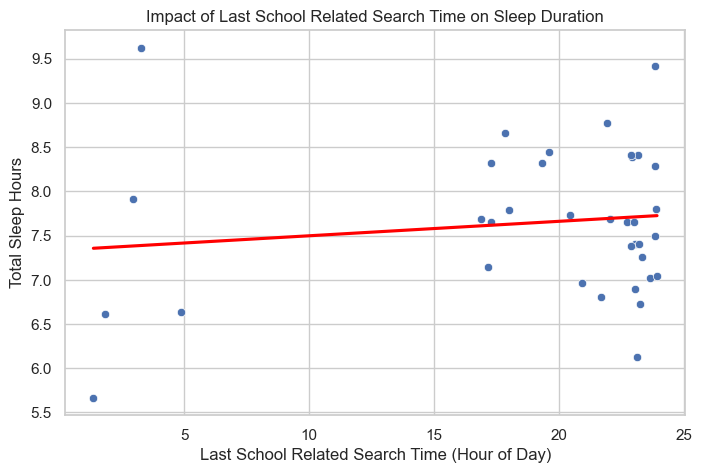

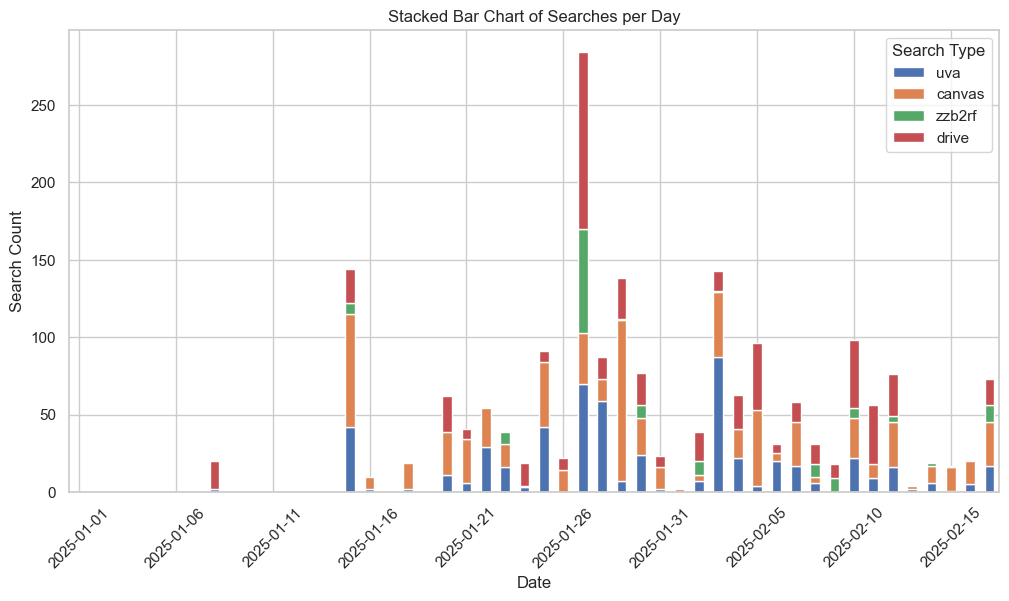

In [110]:
# NOW lets analyze with Sleep
sleep_df["Date"] = pd.to_datetime(sleep_df["Date"])
keywords_df["date"] = pd.to_datetime(keywords_df["date"])
merged_df = keywords_df.merge(sleep_df, left_on="date", right_on="Date", how="left")

plt.figure(figsize=(8,5))
sns.scatterplot(x=merged_df["last_time"], y=merged_df["total_sleep_hours"])
sns.regplot(data=merged_df, x="last_time", y="total_sleep_hours", scatter=False, color="red", ci=None)  # Trendline
plt.xlabel("Last School Related Search Time (Hour of Day)")
plt.ylabel("Total Sleep Hours")
plt.title("Impact of Last School Related Search Time on Sleep Duration")
plt.show()


# Ensure 'Date' is in datetime format
merged_df["date"] = pd.to_datetime(merged_df["date"]).dt.date
ax = merged_df.set_index("date")[["uva", "canvas", "zzb2rf", "drive"]].plot(kind="bar", stacked=True, figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Search Count")
plt.title("Stacked Bar Chart of Searches per Day")
plt.legend(title="Search Type")
plt.xticks(rotation=45)
ax.set_xticks(range(0, len(merged_df), 5))  
ax.set_xticklabels(merged_df["date"][::5], rotation=45)  
plt.show()


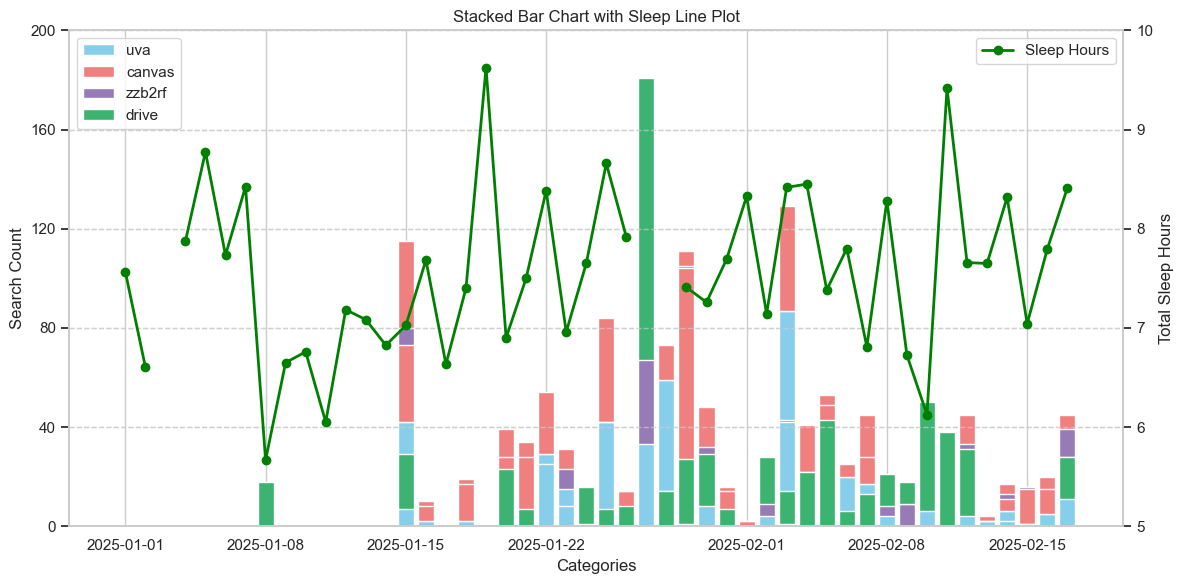

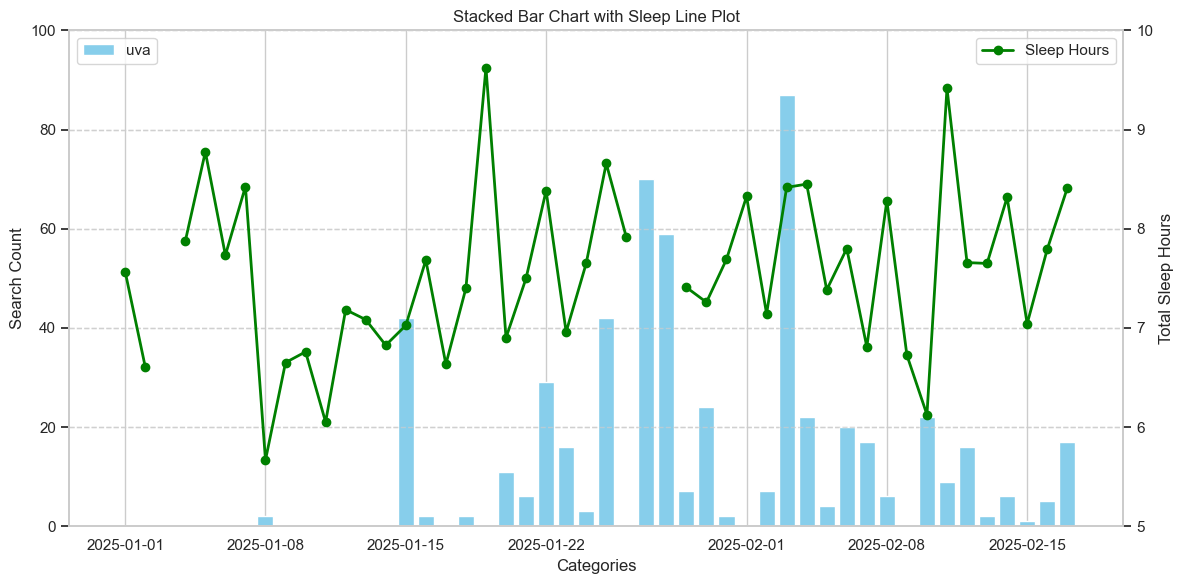

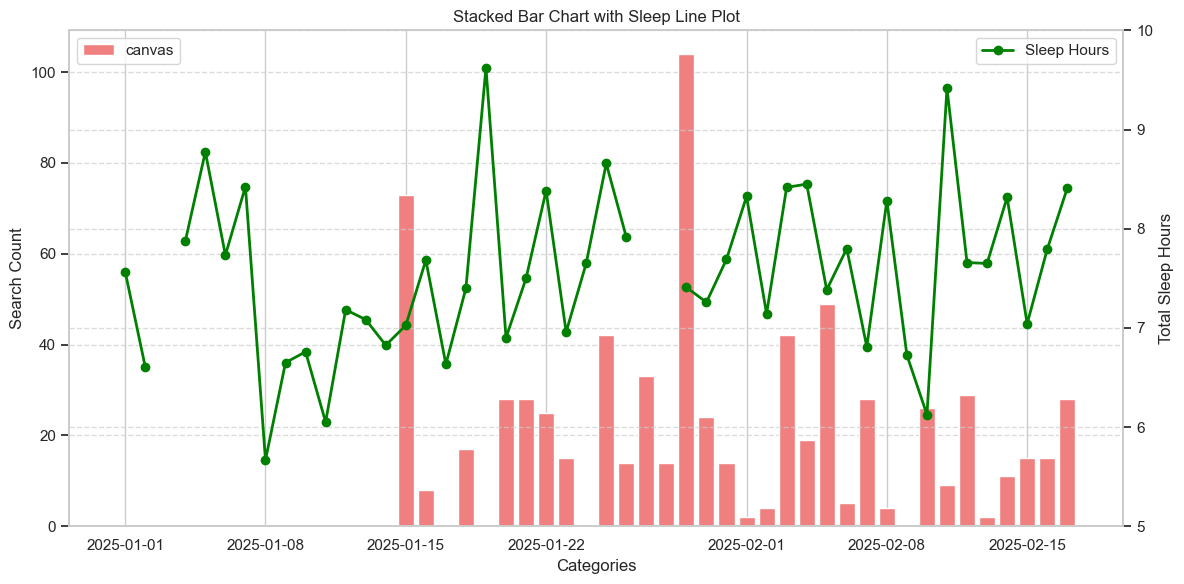

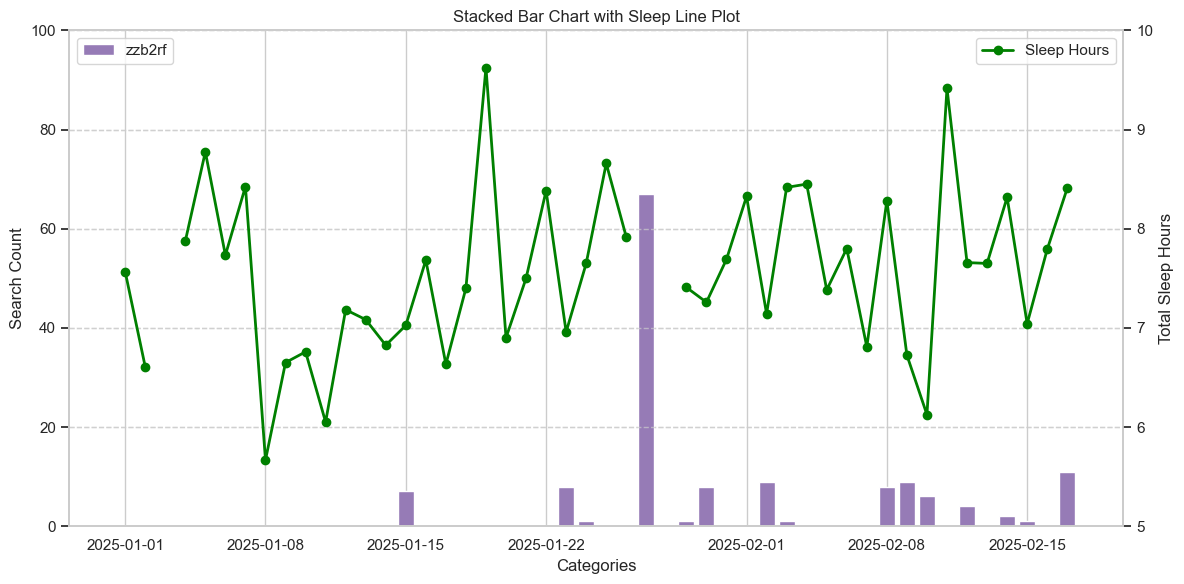

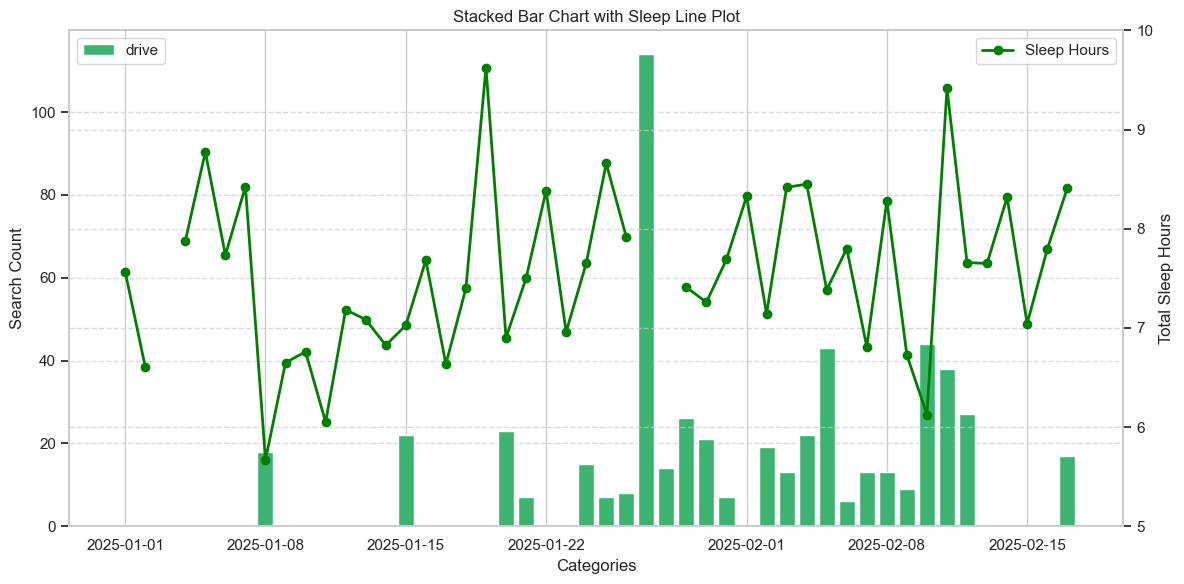

In [111]:
# School related searches and sleep hours
categories = merged_df['date']
data_series_1 = merged_df['uva']
data_series_2 = merged_df['canvas']
data_series_3 = merged_df['zzb2rf']
data_series_4 = merged_df['drive']
line_data = merged_df['total_sleep_hours']

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.bar(categories, data_series_1, label='uva', color='skyblue')
ax1.bar(categories, data_series_2, bottom=data_series_1, label='canvas', color='lightcoral')
ax1.bar(categories, data_series_3, bottom=data_series_2, label='zzb2rf', color='#967bb6')
ax1.bar(categories, data_series_4, bottom=data_series_3, label='drive', color='#3CB371')

ax1.set_xlabel('Categories')
ax1.set_ylabel('Search Count')
ax1.set_title('Stacked Bar Chart with Sleep Line Plot')

ax2 = ax1.twinx()
ax2.plot(categories, line_data, marker='o', linestyle='-', color='green', label='Sleep Hours', linewidth=2)
ax2.set_ylabel('Total Sleep Hours')
ax2.set_ylim(0, merged_df['total_sleep_hours'].max() + 1)

ax1.set_yticks([0, 40, 80, 120, 160, 200])
ax2.set_yticks([5, 6, 7, 8, 9, 10])
ax2.set_ylim(5, 10)

ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# uva keyword searches
categories = merged_df['date']
data_series_1 = merged_df['uva']

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.bar(categories, data_series_1, label='uva', color='skyblue')

ax1.set_xlabel('Categories')
ax1.set_ylabel('Search Count')
ax1.set_title('Stacked Bar Chart with Sleep Line Plot')

ax2 = ax1.twinx()
ax2.plot(categories, line_data, marker='o', linestyle='-', color='green', label='Sleep Hours', linewidth=2)
ax2.set_ylabel('Total Sleep Hours')
ax2.set_ylim(0, merged_df['total_sleep_hours'].max() + 1)

ax1.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_yticks([5, 6, 7, 8, 9, 10])
ax2.set_ylim(5, 10)

ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# canvas keyword searches
categories = merged_df['date']
data_series_1 = merged_df['canvas']

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.bar(categories, data_series_1, label='canvas', color='lightcoral')

ax1.set_xlabel('Categories')
ax1.set_ylabel('Search Count')
ax1.set_title('Stacked Bar Chart with Sleep Line Plot')

ax2 = ax1.twinx()
ax2.plot(categories, line_data, marker='o', linestyle='-', color='green', label='Sleep Hours', linewidth=2)
ax2.set_ylabel('Total Sleep Hours')
ax2.set_ylim(0, merged_df['total_sleep_hours'].max() + 1)

ax1.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_yticks([5, 6, 7, 8, 9, 10])
ax2.set_ylim(5, 10)

ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# zzb2rf keyword searches
categories = merged_df['date']
data_series_1 = merged_df['zzb2rf']

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.bar(categories, data_series_1, label='zzb2rf', color='#967bb6')

ax1.set_xlabel('Categories')
ax1.set_ylabel('Search Count')
ax1.set_title('Stacked Bar Chart with Sleep Line Plot')

ax2 = ax1.twinx()
ax2.plot(categories, line_data, marker='o', linestyle='-', color='green', label='Sleep Hours', linewidth=2)
ax2.set_ylabel('Total Sleep Hours')
ax2.set_ylim(0, merged_df['total_sleep_hours'].max() + 1)

ax1.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_yticks([5, 6, 7, 8, 9, 10])
ax2.set_ylim(5, 10)

ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# drive keyword searches
categories = merged_df['date']
data_series_1 = merged_df['drive']

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.bar(categories, data_series_1, label='drive', color='#3CB371')

ax1.set_xlabel('Categories')
ax1.set_ylabel('Search Count')
ax1.set_title('Stacked Bar Chart with Sleep Line Plot')

ax2 = ax1.twinx()
ax2.plot(categories, line_data, marker='o', linestyle='-', color='green', label='Sleep Hours', linewidth=2)
ax2.set_ylabel('Total Sleep Hours')
ax2.set_ylim(0, merged_df['total_sleep_hours'].max() + 1)

ax1.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_yticks([5, 6, 7, 8, 9, 10])
ax2.set_ylim(5, 10)

ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

